# Notebook de debug

notebook para ir probando algunas cosas en vivo sin tener que recurrir al navegador

# Setup del notebook

Cosas previas a tener seteadas para que el codigo funcione

In [1]:
import sqlite3
import pandas as pd
import os

In [2]:
THIS_FOLDER = os.path.dirname(os.path.abspath("__file__"))
THIS_FOLDER

'/home/tomas/workspace/uba/sr/sr-tpfinal-gh-web'

In [3]:
interacciones = 'interactions'
items = 'repositories'
users = 'users'

# Datasets

carga de los datasets desde la base sqlite

In [4]:
con = sqlite3.connect(os.path.join(THIS_FOLDER, "data/data.db"))
df_int = pd.read_sql_query(f"SELECT * FROM {interacciones}", con)
original_df_items = pd.read_sql_query(f"SELECT * FROM {items}", con)
df_users = pd.read_sql_query(f"SELECT * FROM {users}", con)
con.close()

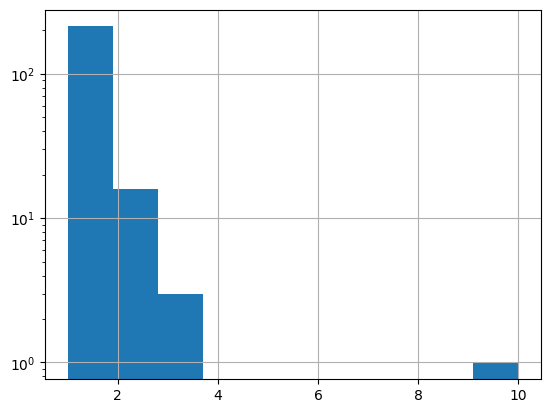

In [5]:
#original_df_items.archived.value_counts()
original_df_items.forks.value_counts().hist(log=True);

In [6]:
df_items = original_df_items.drop(["es_fork", "about", "archived", "topics", "language"], axis=1)

In [7]:
df_int

,index,repository,user,date,like
0,0.0,tensorflow/tensorflow,mrry,2015-11-09 13:17:30,1
1,1.0,tensorflow/tensorflow,danbri,2015-11-09 13:18:49,1
2,2.0,tensorflow/tensorflow,rockt,2015-11-09 13:40:12,1
3,3.0,tensorflow/tensorflow,petro-rudenko,2015-11-09 13:40:58,1
4,4.0,huggingface/transformers,kashif,2018-11-05 15:19:44,1
...,...,...,...,...,...
22020,NaN,NicolasHug/Surprise,fly51fly,2023-11-27 19:39:14,0
22021,NaN,activeloopai/deeplake,fly51fly,2023-11-27 19:39:36,1
22022,NaN,Yorko/mlcourse.ai,fly51fly,2023-11-27 19:39:37,1
22023,NaN,SerpentAI/SerpentAI,fly51fly,2023-11-27 19:39:38,1


# Trabajando con los lenguajes

Se trabaja con los lenguajes de programación

In [44]:
df_languaje_dummies = original_df_items.language.str.get_dummies(sep=";")
df_perfil_items = pd.concat([df_items, df_languaje_dummies], axis=1)

# este perfil se puede precalcular offline y modificarlo ante cada cambio
df_perfil_items

In [81]:
username = "fly51fly" # usuario de quien construiremos el perfil
repos_user = df_int.loc[
    (df_int["user"] == username)
    & (df_int["like"] == 1),
    "repository"].to_list()

# me quedo con el perfil del usuario de los repos que le gustaron
#perfil_user = df_perfil_items[df_perfil_items["id"].isin(repos_user)].drop(columns=["id", "index"]).sum(axis=0).sort_values(ascending=False)
#perfil_user = df_perfil_items[df_perfil_items["id"].isin(repos_user)].drop(columns=["id", "index"]).sum(axis=0)#.reset_index()
perfil_user = df_perfil_items[df_perfil_items["id"].isin(repos_user)].drop(columns=["id", "index", "stars", "watchers", "forks", "issues", "subscribers"]).sum(axis=0).sort_values(ascending=False)
perfil_user = perfil_user / perfil_user.sum() # normalizo

# este perfil se puede precalcular offline y modificarlo ante cada cambio
perfil_user


#df_perfil = pd.concat([df_perfil, df_perfil_items["id"]], axis=1)
#df_perfil_items

Python              0.201657
Shell               0.129834
Dockerfile          0.082873
Jupyter Notebook    0.066298
HTML                0.052486
                      ...   
GDB                 0.000000
PureBasic           0.000000
GAP                 0.000000
Jsonnet             0.000000
AIDL                0.000000
Length: 99, dtype: float64

In [86]:
df_perfil_user = df_perfil_items.drop(columns=["index", "stars", "watchers", "forks", "issues", "subscribers"]).set_index("id").copy()

# por ahora dimension son lenguajes, pero podria haber topics
for dimension in df_perfil_user.columns:
    #print(perfil_user[dimension])
    df_perfil_user[dimension] = df_perfil_user[dimension] * perfil_user[dimension]

recomendacion = df_perfil_user.sum(axis=1).sort_values(ascending=False)[:10].index
list(recomendacion)

['pytorch/pytorch',
 'catboost/catboost',
 'ray-project/ray',
 'TarrySingh/Artificial-Intelligence-Deep-Learning-Machine-Learning-Tutorials',
 'spmallick/learnopencv',
 'h2oai/h2o-3',
 'tensorflow/tensorflow',
 'microsoft/computervision-recipes',
 'mage-ai/mage-ai',
 'microsoft/CNTK']